In [1]:
from __future__ import print_function

import os,sys,math
from keras.models import Sequential, load_model
from keras.models import Model
from keras.datasets import mnist
from keras.layers import *
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical,plot_model

nnscript = os.path.abspath('../../../../Scripts/NNFunctions')
sys.path.append(nnscript)
from fully_connected_opt_weight_generation import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
def showP(d, f, n=None):
    if(n==None):
        R = 1
    else:
        R = n
    for i in range(R):
        if(i%10==0):
            N = R-i
            if(N > 10): N = 10
            fig, axs = plt.subplots(1, N)
        I = i + f
        im = np.asarray(d[0][I]).reshape(28,28)
        try:
            ax = axs[i%N]
        except:
            ax = axs
        ax.imshow(im)
        label =  d[1][I].argmax()
        ax.set_title(label)

def f2q(d, Q):
    '''To convert a number from floating point to Qm.n format:
        1. Multiply the floating point number by 2n
        2. Round to the nearest integer
    '''
    if(type(d) is list):
        D = []
        for v in d:
            D.append(int(v*math.pow(2,Q)+0.5))
    elif(type(d) is np.ndarray):
        D = int(d*math.pow(2,Q)+0.5)
    else:
        D = int(d*math.pow(2,Q)+0.5)
    return D

def ToList(d):
    sz=1
    for s in d.shape:
        sz = sz*s
    return d.reshape(sz).tolist()

def q2f(d, Q):
    '''To convert a number from Qm.n format to floating point:
        1. Convert the number to floating point as if it were an integer, in other words remove the binary point
        2. Multiply by 2−n
    '''
    if(type(d) is np.ndarray):
        d = ToList(d)
    if(type(d) is list):
        D = []
        for v in d:
            D.append(float(v*math.pow(2,-Q)))
    elif(type(d) is np.ndarray):
        D = d*math.pow(2,-Q)
    else:
        D = float(d*math.pow(2,-Q))
    return D

def save(w,name):
    if(type(w) is np.ndarray):
        aL = ToList(w)
    else:
        aL = list(w)
    MIN,MAX=min(aL),max(aL)
    Q = int(np.ceil(np.log2(max(abs(MIN),abs(MAX)))))
    Q = 7-Q
    qL = np.asarray(f2q(aL,Q),np.int8)
    qL.tofile('tmp/%s.raw'%(name))
    return qL,Q

def showW(w, name):
    if(type(w) is np.ndarray):
        aL = ToList(w)
    else:
        aL = list(w)
    MIN,MAX=min(aL),max(aL)
    Q = int(np.ceil(np.log2(max(abs(MIN),abs(MAX)))))
    Q = 7-Q
    qL = np.asarray(f2q(aL,Q),np.int8)
    qL = q2f(ToList(qL),Q)
    plt.figure(figsize=(18, 3))  
    plt.subplot(131)
    plt.title(name)
    plt.plot(aL)
    plt.grid()
    aL.sort()
    plt.plot(aL,'r')
    plt.grid()
    plt.subplot(132)
    plt.title('Q%s'%(Q))
    qL.sort()
    plt.plot(aL,'r')
    plt.plot(qL,'g')
    plt.grid()
    plt.subplot(133)
    plt.hist(aL,100)
    plt.title('hist')
    plt.grid()
    plt.show()

def show(a1, a2=None, a3=None):
    if(type(a2) == str):
        showW(a1, a2)
    else:
        showP(a1, a2, a3)


def compare(a,b,name):
    if(type(a) is np.ndarray):
        aL = ToList(a)
    else:
        aL = list(a)
    if(type(b) is np.ndarray):
        bL = ToList(b)
    else:
        bL = list(b)
    assert(len(aL) == len(bL))
    Z = list(zip(aL,bL))
    Z.sort(key=lambda x: x[0])
    aL1,bL1=zip(*Z)
    plt.figure(figsize=(18, 3))
    plt.subplot(131)
    plt.plot(aL)
    plt.plot(aL1,'r')
    plt.grid()
    plt.title('tf-%s'%(name))
    plt.subplot(133)
    plt.plot(bL1,'g')
    plt.plot(aL1,'r')
    plt.grid()
    plt.title('compare')
    plt.subplot(132)
    bL1=list(bL1)
    bL1.sort()
    plt.plot(bL)
    plt.plot(bL1,'g')
    plt.grid()
    plt.title('nn-%s'%(name))

def RunSysCmd(cmd):
    import subprocess
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    (output, err) = p.communicate()
    p_status = p.wait()
    print(output.decode('utf-8'))

def Download(url, force=False):
    tgt = os.path.basename(url)
    if(os.path.exists(tgt) and force):
        RunSysCmd('rm -f %s'%(tgt))
    if(not os.path.exists(tgt)):
        RunSysCmd('wget %s'%(url))
    return tgt

In [3]:
#https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
def KModel(x_train, y_train, x_test, y_test):
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)/255.0
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)/255.0
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    x = Input(shape=x_train.shape[1:])

    conv1 = Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same')(x)
    h_conv1 = ReLU()(conv1)
    h_pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(h_conv1)
    
    conv2 = Conv2D(64, (5, 5), strides=(1, 1), padding='same')(h_pool1)
    h_conv2 = ReLU()(conv2)
    h_pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(h_conv2)
    
    flat1 = Flatten()(h_pool2)
    fc1 = Dense(1024)(flat1)
    h_fc1 = ReLU()(fc1)
    
    fc2 = Dense(10)(h_fc1)

    y = Softmax()(fc2)
    
    model = Model(inputs=x, outputs=y)
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=128, epochs=12, verbose=1, validation_data=(x_test, y_test))
    return model

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
if(os.path.exists('model.h5')):
    model = load_model('model.h5')
else:
    model = KModel(x_train, y_train, x_test, y_test)
    model.save('model.h5')

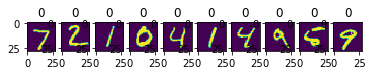

In [6]:
show((x_test,y_test), 0, 10)

In [7]:
plot_model(model, to_file='model.png', show_shapes=True)

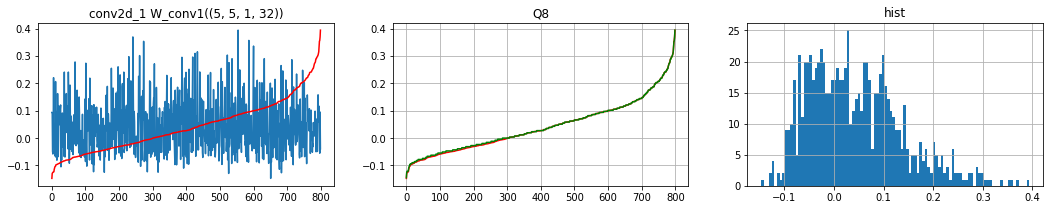

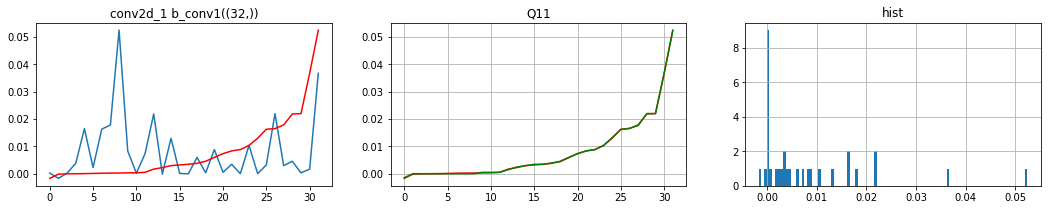

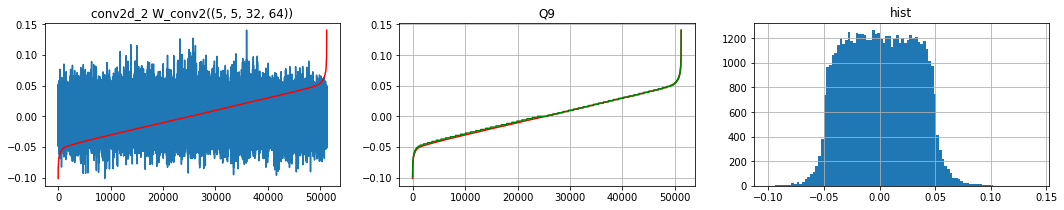

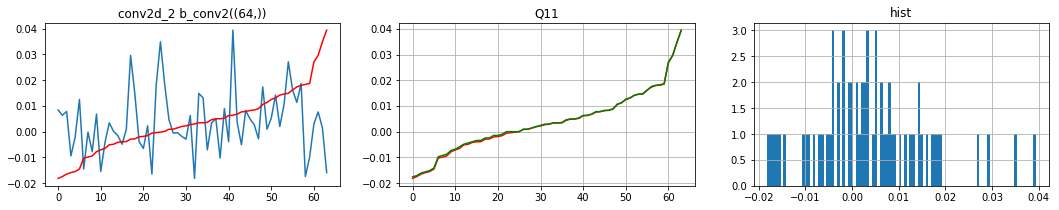

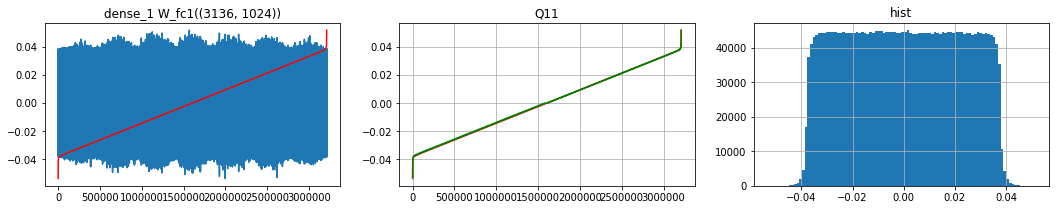

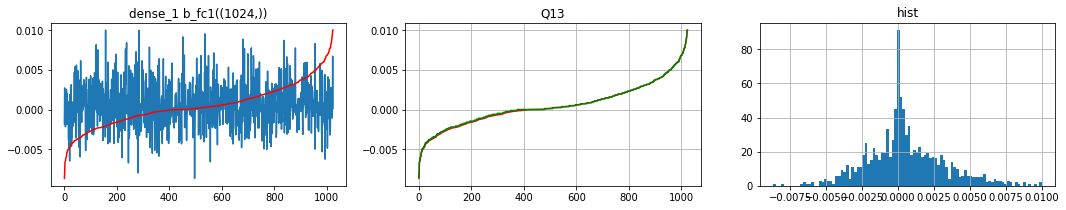

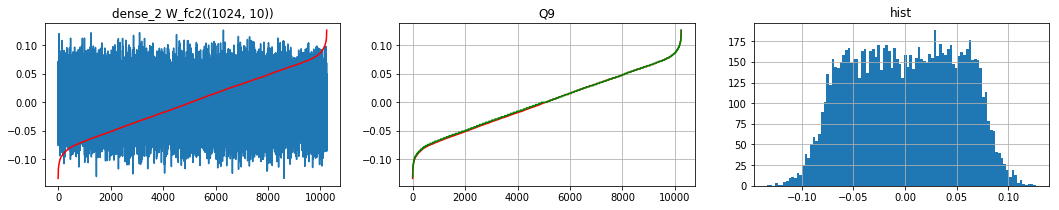

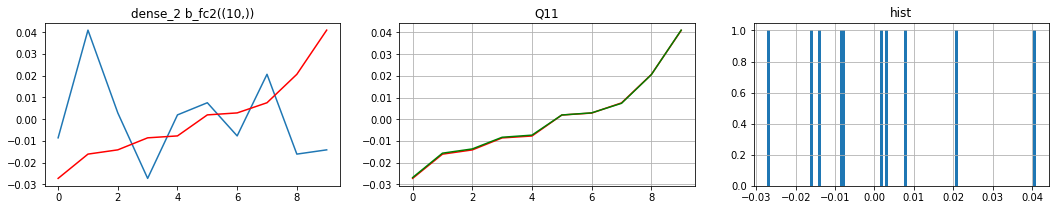

In [8]:
RunSysCmd('rm -fr tmp && mkdir tmp')
wmp = {'conv2d_1:0':'W_conv1', 'conv2d_1:1':'b_conv1', 'conv2d_2:0':'W_conv2', 'conv2d_2:1':'b_conv2',
       'dense_1:0': 'W_fc1', 'dense_1:1': 'b_fc1', 'dense_2:0': 'W_fc2', 'dense_2:1': 'b_fc2'}
lmpNNOM = {'conv2d_1':['Conv2D1',None], 're_lu_1':['ReLU1',None], 'max_pooling2d_1':['Maxpool1',None],
         'conv2d_2':['Conv2D2',None], 're_lu_2':['ReLU2',None], 'max_pooling2d_2':['Maxpool2',None],
         'dense_1':['Dense1',None], 're_lu_3':['ReLU3',None], 'dense_2':['Dense2',None], 
         'softmax_1':['Softmax1',7]}

lmp = {'conv2d_1':['conv1',None], 're_lu_1':['relu1',None], 'max_pooling2d_1':['pool1',None],
             'conv2d_2':['conv2',None], 're_lu_2':['relu2',None], 'max_pooling2d_2':['pool2',None],
             'dense_1':['fc1',None], 're_lu_3':['relu3',None], 'dense_2':['fc2',None], 
             'softmax_1':['y',7]}

fp = open('code/weights.h','w')
X = x_test[5]/255.0
X = X.reshape(1,28,28,1)
qL,Q=save(X,'input')
fp.write('#define INPUT_Q %s\n'%(Q))

for layer in model.layers[1:]:
    if(layer.name in ['flatten_1','softmax_1']):continue
    layer_model = Model(inputs=model.input, outputs=layer.output)
    outR = layer_model.predict(X)
    qL,Q = save(outR,'tmpO')
    lmp[layer.name][1] = Q
    fp.write('#define %s_OUT_Q %s\n'%(lmp[layer.name][0].upper(), Q))

for layer in model.layers:
    for i, wt in enumerate(layer.get_weights()):
        name = wmp['%s:%s'%(layer.name,i)]
        show(wt, '%s %s(%s)'%(layer.name, name, wt.shape))
        if(len(wt.shape)==4):
            wt = wt.transpose(3, 0, 1, 2)
        elif(name in ['W_fc1', 'W_fc2']):
            wt = wt.transpose(1,0)
            wtq,Q = save(wt,name)
            wtq2 = convert_to_x4_q7_weights(wtq.reshape(wt.shape[0],wt.shape[1],1,1))
            wtq2.tofile('tmp/%s_opt.raw'%(name))   
        qL,Q = save(wt,name)
        fp.write('#define %s_Q %s\n'%(wmp['%s:%s'%(layer.name,i)].upper(), Q))
fp.close()

In [9]:
RunSysCmd('scons')
RunSysCmd('./mnist')

scons: Reading SConscript files ...
scons: done reading SConscript files.
scons: Building targets ...
CC code/main.c
LINK mnist
scons: done building targets.

loading input&weights...

INFO: Start compile...
Layer        Activation    output shape      ops          memory            mem life-time
----------------------------------------------------------------------------------------------
            -          - (  28,  28,   1)        0   (  784,  784,    0)    1 - - -  - - - - 
            -          - (  28,  28,  32)   627200   (  784,25088, 3200)    1 1 - -  - - - - 
            -          - (  28,  28,  32)        0   (25088,25088,    0)    - - 1 -  - - - - 
            -          - (  14,  14,  32)        0   (25088, 6272,    0)    1 - 1 -  - - - - 
            -          - (  14,  14,  64)  10035200   ( 6272,12544, 6400)    1 1 - -  - - - - 
            -          - (  14,  14,  64)        0   (12544,12544,    0)    - - 1 -  - - - - 
            -          - (   7,   7,  64) 

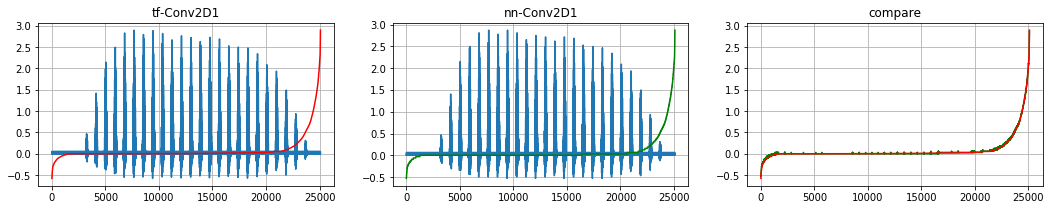

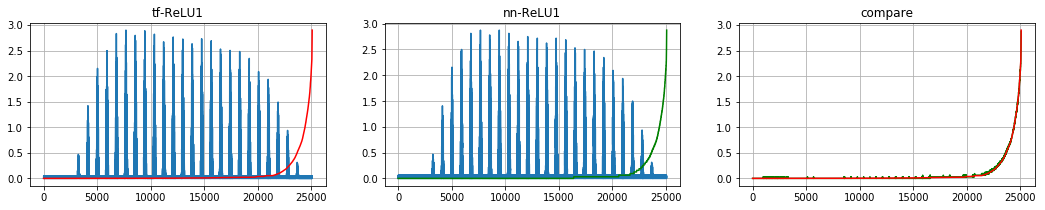

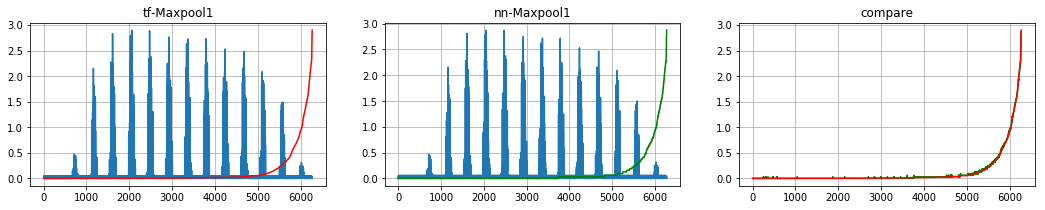

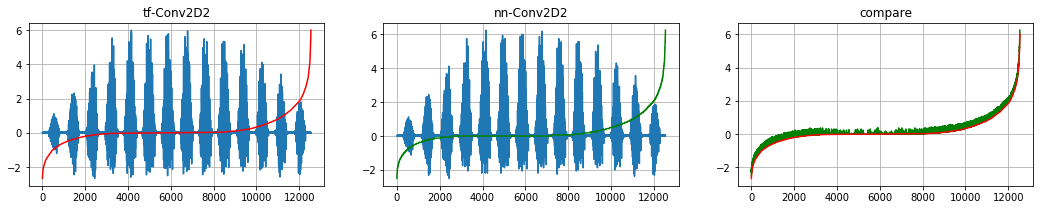

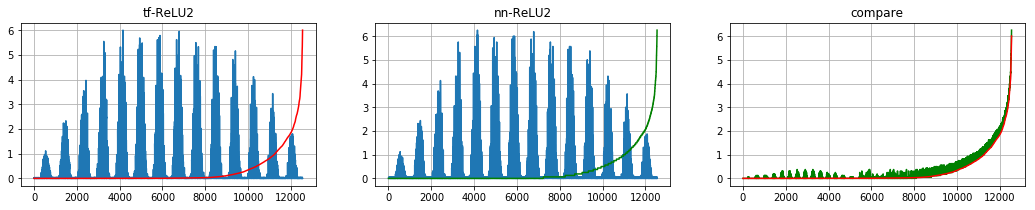

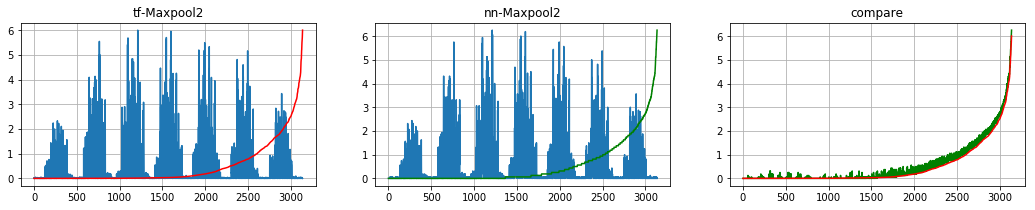

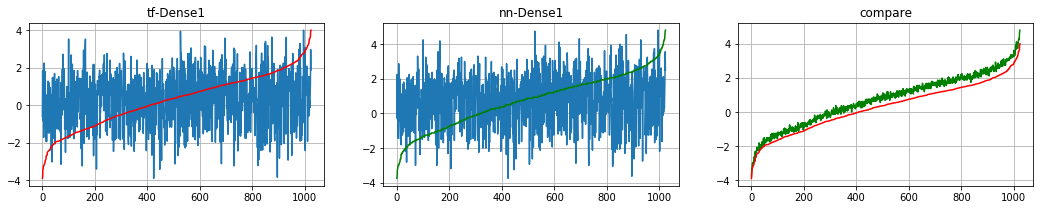

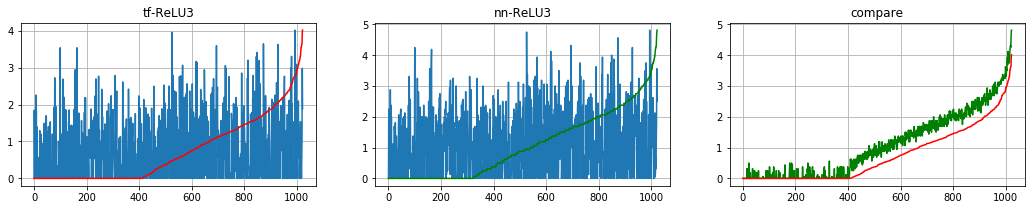

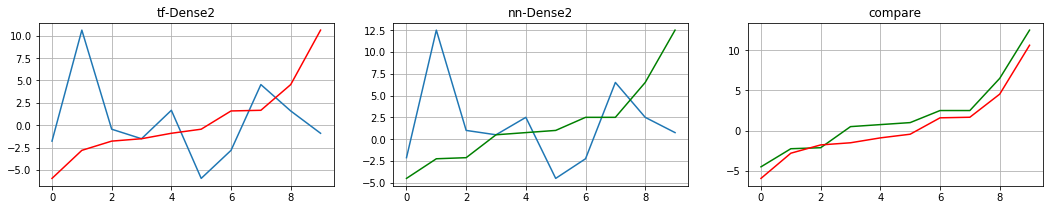

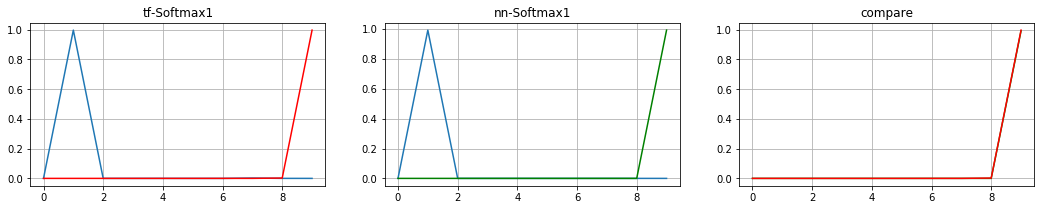

In [10]:
X = X.reshape(1,28,28,1)
for layer in model.layers[1:]:
    if(layer.name in ['flatten_1']):continue
    layer_model = Model(inputs=model.input, outputs=layer.output)
    outR = layer_model.predict(X)
    name,Q = lmp[layer.name]
    if(os.path.exists('nnom')):
        name = lmpNNOM[layer.name][0]
        out = q2f(np.fromfile('tmp/%s.raw'%(name),dtype=np.int8),Q)
    else:
        out = q2f(np.fromfile('tmp/%s_out.raw'%(name),dtype=np.int8),Q)
    compare(outR,out, name)

In [11]:
rP = 0
for i,im in enumerate(x_test):
    X = im/255.0
    X = X.reshape(1,28,28,1)
    qL,Q=save(X,'input')
    if(0 == os.system('./mnist > /dev/null')):
        out = q2f(np.fromfile('tmp/y_out.raw',dtype=np.int8),7)
        out = np.asarray(out)
        num, prop = out.argmax(), out[out.argmax()]
        rnum = y_test[i]
        if((rnum == num) and (prop > 0.8)):
            #print('test image %d is %d, predict correctly with prop %s'%(i, rnum, prop))
            rP += 1
        if((i>0) and ((i%100)==0)):
            print('%.1f%%(%s) out of %s is correct predicted'%(rP*100.0/i, rP, i))
            break

print('%.1f%%(%s) out of %s is correct predicted'%(rP*100.0/i, rP, i))

97.0%(97) out of 100 is correct predicted
97.0%(97) out of 100 is correct predicted
